# Розпізнавання об'єктів на зображеннях з набору даних CIFAR-10

## Prapare import / variable

In [32]:
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import Adam

import os
# %matplotlib inline

In [31]:
# Розмір міні-вибірки
batch_size = 16
# Кількість епох для навчання
epochs = 10
# Розмір зображеннь
img_width, img_height = 150, 150
img_size = (img_width, img_height)
# Кількість каналів в зображенні
img_channels = 3
Image_rgb_size = (img_width, img_height, img_channels)

# Кількість класів зображень
nb_classes = 2
# Назви класів
classes = ['кіт', 'собака']

imgs downloaded from: https://www.microsoft.com/en-us/download/details.aspx?id=54765

In [3]:
# Частина набору даних для тестування
test_data_portion = 0.15
# Частина набору даних для перевірки
val_data_portion = 0.15

nb_images = 12500

nb_train_samples = nb_images * 2 * (1 - test_data_portion - val_data_portion)
nb_test_samples = nb_val_samples = nb_images * 2 * val_data_portion
nb_train_samples, nb_val_samples, nb_test_samples

# Каталог з набором даних
data_dir = 'PetImages'

# Каталог з даними для навчання
train_dir = 'train'
# Каталог з даними для перевірки
val_dir = 'val'
# Каталог з даними длятестування
test_dir = 'test'

## Prapare data

### Create folder

In [59]:
import shutil

def create_directory(dir_name):
    if os.path.exists(dir_name):
        shutil.rmtree(dir_name)
    os.makedirs(dir_name)
    os.makedirs(os.path.join(dir_name,"cats"))
    os.makedirs(os.path.join(dir_name,"dogs"))

In [60]:
create_directory(train_dir)
create_directory(val_dir)
create_directory(test_dir)

### Find and remove corrupted image

In [62]:
import os
from PIL import Image
count = 0
dir_path1 = os.path.join(data_dir, "Cat")
dir_path2 = os.path.join(data_dir, "Dog")
for mydir in dir_path1,dir_path2:
    for filename in os.listdir(mydir):
        if filename.endswith('.jpg'):
            try:
                img = Image.open(os.path.join(mydir, filename))
                img.verify()
                img.close()
            except(IOError, SyntaxError)as e:
                print('Bad file to delete :  '+mydir+"\\"+filename)
                count = count+1
                os.remove(os.path.join(mydir, filename))
print(count)


Bad file to delete :  666.jpg
1


c:\Users\Kolyanys\AppData\Local\Programs\Python\Python39\lib\site-packages\PIL\TiffImagePlugin.py:811: UserWarning: Truncated File Read
  warnings.warn(str(msg))


### Copy to folder

In [63]:
import shutil

def copy_images(start_index, end_index, source_dir, dest_dir):
    for i in range(start_index, end_index):
        source_path = os.path.join(source_dir, "Cat", str(i) + ".jpg")
        if os.path.exists(source_path):
            shutil.copy2(
                source_path,
                os.path.join(dest_dir, "cats")
            )
        source_path = os.path.join(source_dir, "Dog", str(i) + ".jpg")
        if os.path.exists(source_path):
            shutil.copy2(
                source_path,
                os.path.join(dest_dir, "dogs")
            )

In [64]:
start_val_data_idx = int(nb_images * (1 - val_data_portion - test_data_portion))
start_test_data_idx = int(nb_images * (1 - test_data_portion))
start_val_data_idx, start_test_data_idx

(8750, 10625)

In [65]:
copy_images(0, start_val_data_idx, data_dir, train_dir)
copy_images(start_val_data_idx, start_test_data_idx, data_dir, val_dir)
copy_images(start_test_data_idx, nb_images, data_dir, test_dir)

## Створюємо нейронну мережу

### DataGenerator

In [33]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)
val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

Found 17499 images belonging to 2 classes.
Found 3750 images belonging to 2 classes.
Found 3749 images belonging to 2 classes.


### Create model on vgg16

In [4]:
from keras.applications.vgg16 import VGG16
vgg16 = VGG16(weights='imagenet',
              include_top=False,
              input_shape=Image_rgb_size)
vgg16.trainable = False
vgg16.summary()

58889256/58889256 [==============================] - 23s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                             

In [7]:
# Створюємо послідовну модель
model = Sequential()
model.add(vgg16)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [8]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=1e-5),
              metrics=['accuracy'])

In [9]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________
None


### Create model on InceptionV3

In [21]:
from keras.applications.inception_v3 import InceptionV3
inception_v3 = InceptionV3(weights='imagenet',
              include_top=False,
              input_shape=Image_rgb_size)
inception_v3.trainable = False
inception_v3.summary()

87910968/87910968 [==============================] - 35s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                     

In [22]:
# Створюємо послідовну модель
model2 = Sequential()
model2.add(inception_v3)
model2.add(Flatten())
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(1, activation='sigmoid'))

In [23]:
model2.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=1e-5),
              metrics=['accuracy'])

In [24]:
print(model2.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 flatten_2 (Flatten)         (None, 18432)             0         
                                                                 
 dense_4 (Dense)             (None, 256)               4718848   
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 26,521,889
Trainable params: 4,719,105
Non-trainable params: 21,802,784
_________________________________________________________________
None


### Create model on ResNet50

In [25]:
from keras.applications.resnet import ResNet50
resNet50 = ResNet50(weights='imagenet',
              include_top=False,
              input_shape=Image_rgb_size)
resNet50.trainable = False
resNet50.summary()

94765736/94765736 [==============================] - 41s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormaliza

In [26]:
# Створюємо послідовну модель
model3 = Sequential()
model3.add(resNet50)
model3.add(Flatten())
model3.add(Dense(256, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(1, activation='sigmoid'))

In [27]:
model3.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=1e-5),
              metrics=['accuracy'])

In [28]:
print(model3.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 flatten_3 (Flatten)         (None, 51200)             0         
                                                                 
 dense_6 (Dense)             (None, 256)               13107456  
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 257       
                                                                 
Total params: 36,695,425
Trainable params: 13,107,713
Non-trainable params: 23,587,712
_________________________________________________________________
None


### Навчаємо нейрону мережу

In [12]:
history = model.fit(
    train_generator,
    epochs = epochs,
    validation_data=val_generator,
    steps_per_epoch=nb_train_samples//batch_size,
    validation_steps=nb_val_samples//batch_size)

Epoch 1/15
1093/1093 [==============================] - ETA: 0s - loss: 0.4162 - accuracy: 0.8068

c:\Users\Kolyanys\AppData\Local\Programs\Python\Python39\lib\site-packages\PIL\TiffImagePlugin.py:811: UserWarning: Truncated File Read
  warnings.warn(str(msg))


1093/1093 [==============================] - 135s 116ms/step - loss: 0.4162 - accuracy: 0.8068 - val_loss: 0.2941 - val_accuracy: 0.8833
Epoch 2/15
1093/1093 [==============================] - 40s 36ms/step - loss: 0.2900 - accuracy: 0.8784 - val_loss: 0.2535 - val_accuracy: 0.8950
Epoch 3/15
1093/1093 [==============================] - 40s 37ms/step - loss: 0.2583 - accuracy: 0.8902 - val_loss: 0.2384 - val_accuracy: 0.9041
Epoch 4/15
1093/1093 [==============================] - 40s 36ms/step - loss: 0.2341 - accuracy: 0.9000 - val_loss: 0.2264 - val_accuracy: 0.9076
Epoch 5/15
1093/1093 [==============================] - 41s 37ms/step - loss: 0.2219 - accuracy: 0.9085 - val_loss: 0.2212 - val_accuracy: 0.9105
Epoch 6/15
1093/1093 [==============================] - 41s 38ms/step - loss: 0.2094 - accuracy: 0.9130 - val_loss: 0.2158 - val_accuracy: 0.9108
Epoch 7/15
1093/1093 [==============================] - 50s 45ms/step - loss: 0.2022 - accuracy: 0.9167 - val_loss: 0.2131 - val_accu

In [34]:
history2 = model2.fit(
    train_generator,
    epochs = epochs,
    validation_data=val_generator,
    steps_per_epoch=nb_train_samples//batch_size,
    validation_steps=nb_val_samples//batch_size)

Epoch 1/10
1092/1093 [============================>.] - ETA: 0s - loss: 0.1773 - accuracy: 0.9362

c:\Users\Kolyanys\AppData\Local\Programs\Python\Python39\lib\site-packages\PIL\TiffImagePlugin.py:811: UserWarning: Truncated File Read
  warnings.warn(str(msg))


1093/1093 [==============================] - 46s 38ms/step - loss: 0.1772 - accuracy: 0.9363 - val_loss: 0.1003 - val_accuracy: 0.9629
Epoch 2/10
1093/1093 [==============================] - 40s 37ms/step - loss: 0.0948 - accuracy: 0.9625 - val_loss: 0.0908 - val_accuracy: 0.9685
Epoch 3/10
1093/1093 [==============================] - 42s 38ms/step - loss: 0.0757 - accuracy: 0.9699 - val_loss: 0.0879 - val_accuracy: 0.9669
Epoch 4/10
1093/1093 [==============================] - 40s 36ms/step - loss: 0.0592 - accuracy: 0.9772 - val_loss: 0.0953 - val_accuracy: 0.9631
Epoch 5/10
1093/1093 [==============================] - 40s 37ms/step - loss: 0.0498 - accuracy: 0.9807 - val_loss: 0.0955 - val_accuracy: 0.9661
Epoch 6/10
1093/1093 [==============================] - 40s 37ms/step - loss: 0.0396 - accuracy: 0.9854 - val_loss: 0.0884 - val_accuracy: 0.9698
Epoch 7/10
1093/1093 [==============================] - 39s 36ms/step - loss: 0.0333 - accuracy: 0.9880 - val_loss: 0.1043 - val_accura

In [35]:
history3 = model3.fit(
    train_generator,
    epochs = epochs,
    validation_data=val_generator,
    steps_per_epoch=nb_train_samples//batch_size,
    validation_steps=nb_val_samples//batch_size)

Epoch 1/10
1093/1093 [==============================] - 46s 39ms/step - loss: 0.6755 - accuracy: 0.5858 - val_loss: 0.6442 - val_accuracy: 0.6231
Epoch 2/10
1093/1093 [==============================] - 41s 38ms/step - loss: 0.6390 - accuracy: 0.6338 - val_loss: 0.6179 - val_accuracy: 0.6701
Epoch 3/10
1093/1093 [==============================] - 41s 38ms/step - loss: 0.6240 - accuracy: 0.6521 - val_loss: 0.6038 - val_accuracy: 0.6851
Epoch 4/10
1093/1093 [==============================] - 41s 38ms/step - loss: 0.6116 - accuracy: 0.6657 - val_loss: 0.5956 - val_accuracy: 0.6830
Epoch 5/10
1093/1093 [==============================] - 41s 37ms/step - loss: 0.6049 - accuracy: 0.6731 - val_loss: 0.5833 - val_accuracy: 0.7035
Epoch 6/10
1093/1093 [==============================] - 41s 38ms/step - loss: 0.5949 - accuracy: 0.6836 - val_loss: 0.5834 - val_accuracy: 0.6979
Epoch 7/10
1093/1093 [==============================] - 41s 38ms/step - loss: 0.5909 - accuracy: 0.6856 - val_loss: 0.5712 -

## Оцінюємо якість  навчання мережі

In [36]:
# Оцінюємо якість навчання моделі на тестових даних 
scores = model.evaluate(test_generator)
print("Точність роботи на тестових даних: %.2f%%" % (scores[1]*100))

235/235 [==============================] - 7s 30ms/step - loss: 0.2043 - accuracy: 0.9149
Точність роботи на тестових даних: 91.49%


In [39]:
# Оцінюємо якість навчання моделі на тестових даних 
scores2 = model2.evaluate(test_generator)
print("Точність роботи на тестових даних: %.2f%%" % (scores2[1]*100))

235/235 [==============================] - 7s 30ms/step - loss: 0.0901 - accuracy: 0.9685
Точність роботи на тестових даних: 96.85%


In [40]:
# Оцінюємо якість навчання моделі на тестових даних 
scores3 = model3.evaluate(test_generator)
print("Точність роботи на тестових даних: %.2f%%" % (scores3[1]*100))

235/235 [==============================] - 7s 30ms/step - loss: 0.5650 - accuracy: 0.7167
Точність роботи на тестових даних: 71.67%


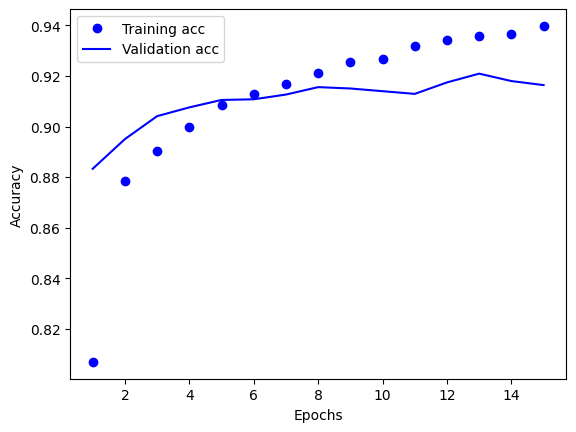

In [41]:
history_dict = history.history
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values) + 1)
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

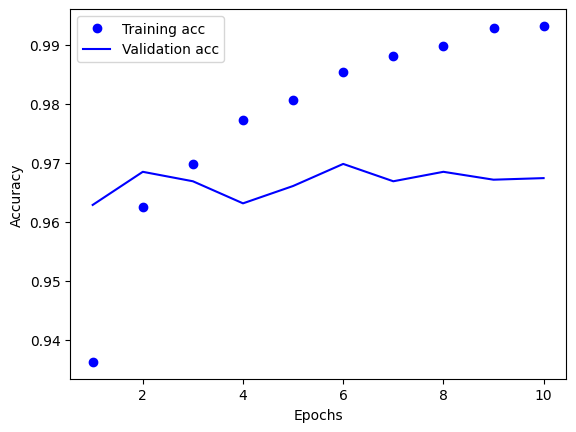

In [42]:
history_dict = history2.history
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values) + 1)
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

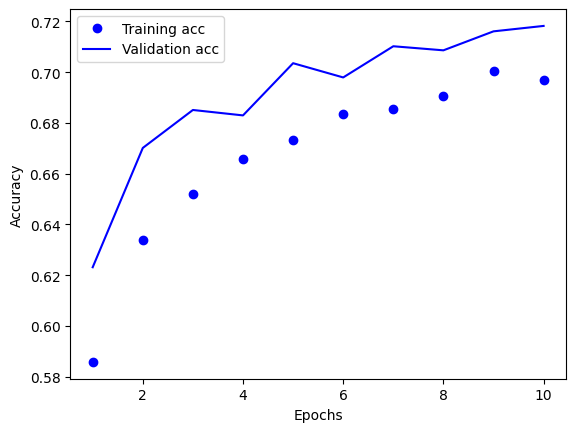

In [44]:
history_dict = history3.history
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values) + 1)
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Зберігаємо навчену нейрону мережу

In [16]:
model.save("Recognition_lab8_vgg16.h5")

In [45]:
model.save("Recognition_lab8_inceptionV3.h5")

In [46]:
model.save("Recognition_lab8_resNet50.h5")

## Завантажуємо попередньо навчену нейронну мережу 


Завантажуємо файл з навченою моделлю 

In [ ]:
#!wget https://github.com/Kolyanuss/Lab_Univer/blob/master/Lab_4k_1sem/Recognise/lab7/Recognition_lab8_vgg16.h5
# f = google.colab.files.upload()

Завантажуємо модель в пам'ять 

In [ ]:
from keras.models import load_model
model = load_model('Recognition_lab8_vgg16.h5')
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 32, 32, 128)       3584      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 16, 16, 128)      0         
 g2D)                                                            
                                                                 
 dropout_30 (Dropout)        (None, 16, 16, 128)       0         
                                                                 
 conv2d_26 (Conv2D)          (None, 16, 16, 256)       295168    
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 8, 8, 256)        0         
 g2D)                                                            
                                                                 
 dropout_31 (Dropout)        (None, 8, 8, 256)        

In [ ]:
from keras.models import load_model
model2 = load_model('Recognition_lab8_inceptionV3.h5')
model2.summary()

In [ ]:
from keras.models import load_model
model3 = load_model('Recognition_lab8_resNet50.h5')
model3.summary()

## Розпізнаємо свої зображення

In [ ]:
# files.upload()

**Дивимось завантажений малюнок**

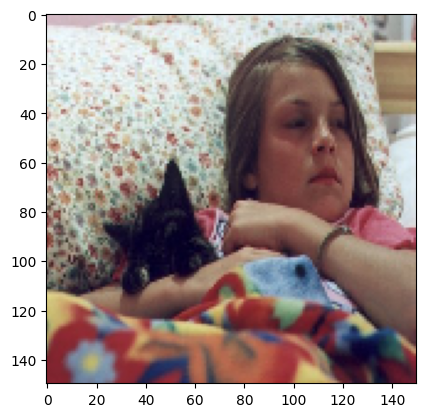

In [19]:
from keras import utils
img_path = 'PetImages\Cat\\6.jpg'
img = utils.load_img(img_path, target_size=img_size)
plt.imshow(img)
plt.show()

**Перетворюємо малюнок в масив для розпізнавання**

In [50]:
x = utils.img_to_array(img)
x /= 255
x = np.expand_dims(x, axis=0)

prediction = model2.predict(x)
print(prediction)
prediction = round(prediction[0][0])
print(classes[prediction])

1/1 [==============================] - 0s 51ms/step
[[0.00675672]]
кіт
